## Imports

In [47]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

## EDC

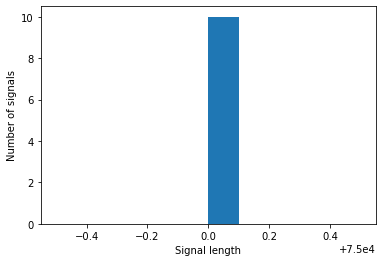

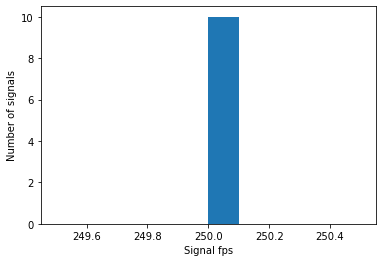

In [48]:
def get_samples_len(folder: str):
    files = [f for f in os.listdir(folder) if f[-4:]=='.dat']
    sig_length = []
    sig_fps = []
    for name in files:
        record =  wfdb.rdrecord(folder+'\\'+name[:-4])
        sig_length.append(record.p_signal.shape[0])
        sig_fps.append(record.fs)
    plt.hist(sig_length)
    plt.xlabel("Signal length")
    plt.ylabel("Number of signals")
    plt.show()
    plt.hist(sig_fps)
    plt.xlabel("Signal fps")
    plt.ylabel("Number of signals")
    plt.show()

get_samples_len("data")


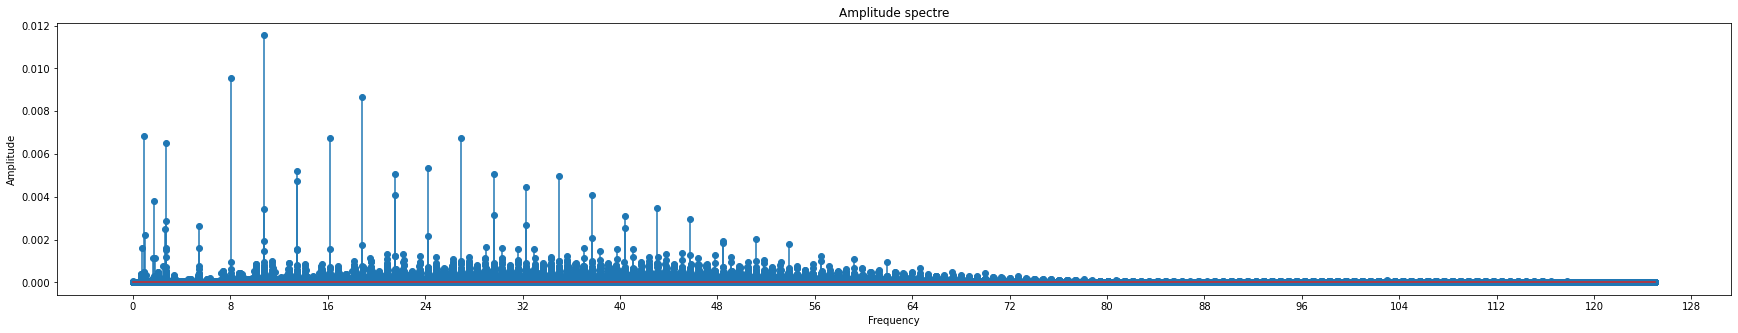

In [49]:
def plot_amplitude_spectre(time_array : np.array, signal : np.array, fs : int):
  fft = 2 * abs(np.fft.fft(signal)) / len(signal)
  frequency = [i * fs / len(time_array) for i in range(int(len(time_array) / 2))]

  f = plt.figure()
  f.set_figwidth(30)
  f.set_figheight(5)

  plt.stem(frequency, fft[:int(len(signal) / 2)], use_line_collection=True)

  plt.xticks(np.arange(0, max(frequency) + 8, 8))

  plt.title(f'Amplitude spectre')
  plt.xlabel('Frequency')
  plt.ylabel('Amplitude')

record = wfdb.rdrecord("data\\sub01_snr12dB_l1_c5_"+'fecg2')
t = np.arange(0, len(record.p_signal.T[0])/record.fs, 1/record.fs)
plot_amplitude_spectre(t, record.p_signal.T[0], record.fs)

## Filtration

In [50]:
import scipy.signal

def bandpass_filter(signal, fs, lowcut= 0.05, highcut=100, order=6):
    b, a = scipy.signal.butter(order, [lowcut, highcut], btype='band', fs=fs)
    filtered_signal = scipy.signal.filtfilt(b, a, signal)
    return filtered_signal

def filter_all_channels(multichaneled_signals, fs, lowcut=0.05, highcut=100, order=4):
    filtered = []
    for channel in multichaneled_signals:
        filtered.append(bandpass_filter(channel, fs, lowcut, highcut, order))
    return np.asarray(filtered)

In [51]:
class ChanneledSignal:
    def __init__(self, fs) -> None:
        self.fs = fs
    def set_maternal_ecg(self, maternal_ecg):
        self.maternal_ecg= maternal_ecg
    def set_fetal_ecgs(self, fetal_ecgs):
        self.fetal_ecgs= fetal_ecgs
    def set_whole_signal(self, whole_signal):
        self.whole_signal = whole_signal

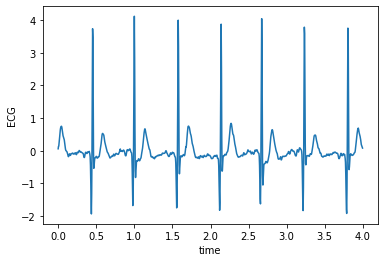

In [52]:
def recreate_whole_signal(experiment_name, fetal_total_num = 1):
    record = wfdb.rdrecord(experiment_name+'mecg')
    chanelled_signal = ChanneledSignal(record.fs)
    maternal_signal = record.p_signal
    noise_signal = wfdb.rdrecord(experiment_name+'noise1').p_signal
    chanelled_signal.set_maternal_ecg(maternal_signal.T)
    whole_signal = maternal_signal + noise_signal
    fetal_ecgs = []

    for i in range(1, fetal_total_num+1):
        fetal_ecg = wfdb.rdrecord(experiment_name+'fecg'+str(i)).p_signal
        fetal_ecgs.append(fetal_ecg.T)
        whole_signal = whole_signal + fetal_ecg

    chanelled_signal.set_fetal_ecgs(fetal_ecgs) 
    # Here we need to transpose the signal to be able to filter out unwanted frequencies.
    chanelled_signal.set_whole_signal(whole_signal.T)
    return chanelled_signal

sub01_snr12dB_l1_c0 = recreate_whole_signal("data\\sub01_snr12dB_l1_c0_")
plt.plot(t[:1000],sub01_snr12dB_l1_c0.whole_signal[32][:1000])
plt.xlabel("time")
plt.ylabel("ECG")
plt.show()

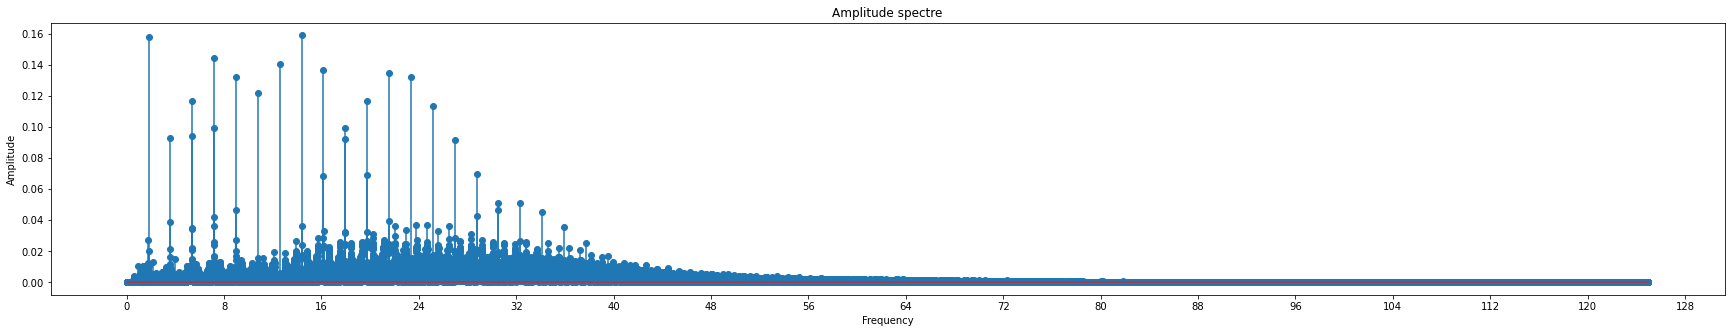

In [53]:
plot_amplitude_spectre(t, sub01_snr12dB_l1_c0.whole_signal[32], record.fs)

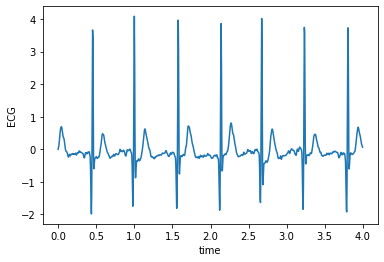

In [54]:
sub01_snr12dB_l1_c0.set_whole_signal(filter_all_channels(sub01_snr12dB_l1_c0.whole_signal, sub01_snr12dB_l1_c0.fs))
plt.plot(t[:1000],sub01_snr12dB_l1_c0.whole_signal[32][:1000])
plt.xlabel("time")
plt.ylabel("ECG")
plt.show()

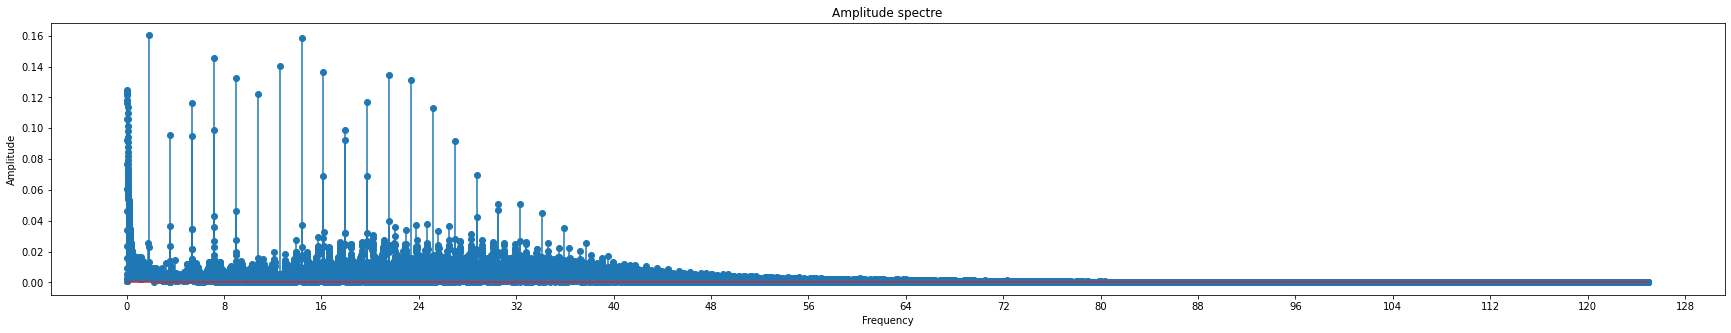

In [55]:
plot_amplitude_spectre(t, sub01_snr12dB_l1_c0.whole_signal[32], record.fs)

## ICA

In [62]:
ica = FastICA(n_components=4, random_state=42, max_iter=800)
ica_result_sub01_snr12dB_l1_c0 = ica.fit_transform(sub01_snr12dB_l1_c0.whole_signal.T)

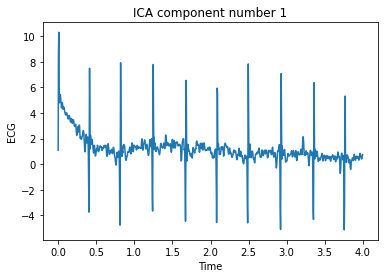

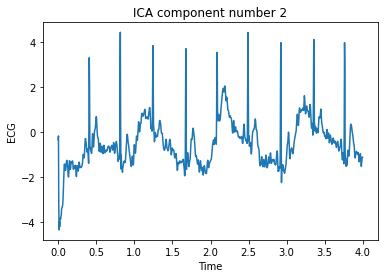

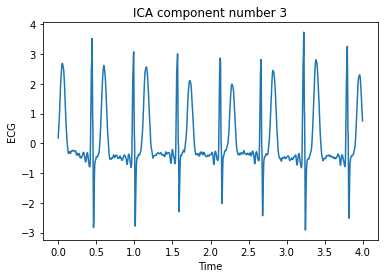

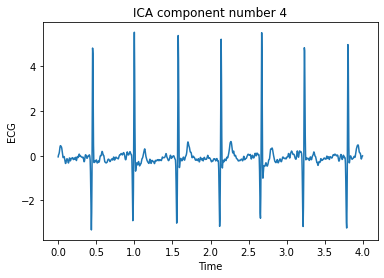

In [63]:
def plot_ica_results(ica_result):
    for i in range(4):
        plt.title(f"ICA component number {i+1}")
        plt.plot(t[:1000], ica_result.T[i][:1000])
        plt.xlabel("Time")
        plt.ylabel("ECG")
        plt.show()
plot_ica_results(ica_result_sub01_snr12dB_l1_c0)

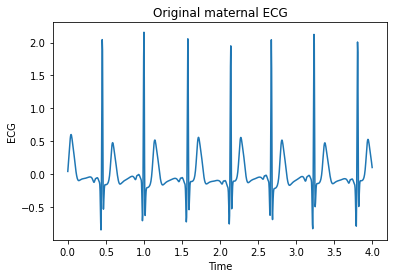

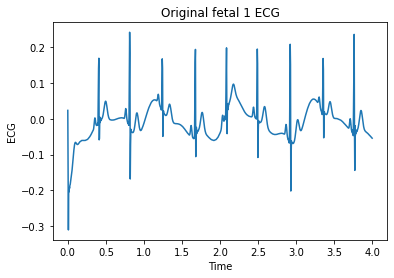

In [60]:
def plot_original_signals(multichanneled_sig):
    plt.plot(t[:1000], multichanneled_sig.maternal_ecg[0][:1000])
    plt.title("Original maternal ECG")
    plt.xlabel("Time")
    plt.ylabel("ECG")
    plt.show()
    for i, fetal_ecg in enumerate(multichanneled_sig.fetal_ecgs):
        plt.plot(t[:1000], fetal_ecg[0][:1000])
        plt.title(f"Original fetal {i+1} ECG")
        plt.xlabel("Time")
        plt.ylabel("ECG")
        plt.show()

plot_original_signals(sub01_snr12dB_l1_c0)

Twins case

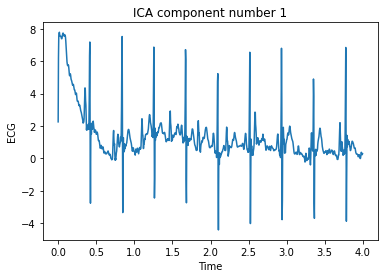

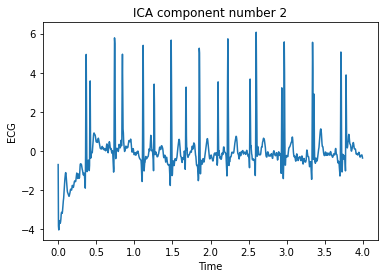

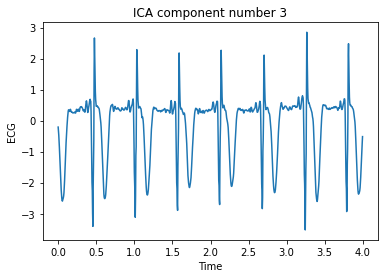

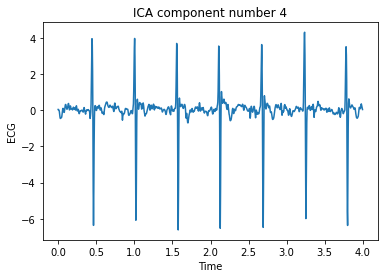

In [64]:
sub01_snr12dB_l1_c5 = recreate_whole_signal("data\\sub01_snr12dB_l1_c5_", fetal_total_num=2)
sub01_snr12dB_l1_c5.set_whole_signal(filter_all_channels(sub01_snr12dB_l1_c5.whole_signal, sub01_snr12dB_l1_c5.fs))
ica_result_sub01_snr12dB_l1_c5 = ica.fit_transform(sub01_snr12dB_l1_c5.whole_signal.T)
plot_ica_results(ica_result_sub01_snr12dB_l1_c5)

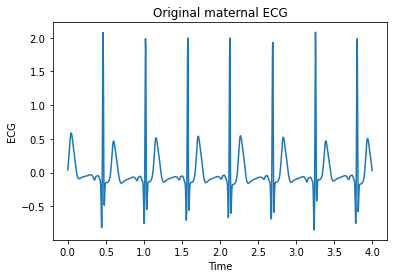

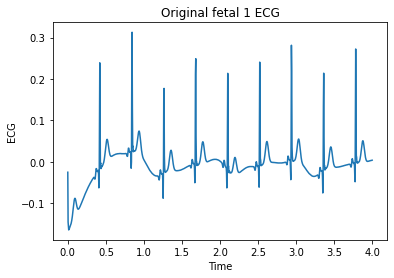

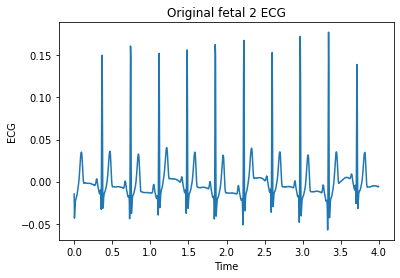

In [65]:
plot_original_signals(sub01_snr12dB_l1_c5)

## R-peaks detection

In [68]:
def find_peaks(signal, height=0.5, distance=1):
    peaks = []
    peak_height = -float('inf')
    peak_index = -1

    for i, value in enumerate(signal):
        if value > peak_height:
            peak_height = value
            peak_index = i

        if value < height and peak_index != -1:
            if len(peaks) == 0 or i - peak_index >= distance:
                peaks.append(peak_index)
                peak_height = -float('inf')
                peak_index = -1

    return np.array(peaks)

def pan_tompkins_ecg(signal, fs):
    # Differentiation
    diff_signal = np.diff(signal)

    # Squaring
    squared_signal = diff_signal ** 2

    # Moving-Window Integration
    integration_window = int(fs * 0.005)
    integrated_signal = np.convolve(squared_signal, np.ones(integration_window) / integration_window, mode='same')

    # Find peaks
    peaks = find_peaks(integrated_signal, height=1, distance=int(fs * 0.3))

    return peaks

def plot_peaks(signal, r_peaks, fs):
    t =  np.arange(0, len(signal)/fs, 1/fs)
    plt.plot(t, signal, label='ECG Signal')
    r_peaks_cropped = list(filter(lambda x: x < len(signal)-1, r_peaks))
    plt.plot(t[r_peaks_cropped], signal[r_peaks_cropped], 'ro', label='R-peaks')
    plt.title('ECG Signal with R-peaks Detection')
    plt.xlabel('Time (s)')
    plt.legend()
    plt.grid(True)
    plt.show()

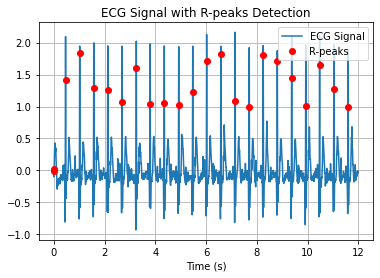

In [69]:
r_peaks_sub01_snr12dB_l1_c5 = pan_tompkins_ecg(sub01_snr12dB_l1_c5.whole_signal[0][:3000], sub01_snr12dB_l1_c5.fs)
plot_peaks(sub01_snr12dB_l1_c5.whole_signal[0][:3000], r_peaks_sub01_snr12dB_l1_c5, sub01_snr12dB_l1_c5.fs)


In [82]:
def calculate_mean_freq(s):
    distance_between = 0
    for i in range(1, len(s)):
        distance_between += s[i] - s[i-1]
    return distance_between / (len(s) - 1)

def calculate_mean_bpm(r_peaks, fs):
    return round(1 / (calculate_mean_freq(r_peaks) / fs) * 60)

In [83]:
calculate_mean_bpm(r_peaks_sub01_snr12dB_l1_c5, sub01_snr12dB_l1_c5.fs)

114

## Pipeline

In [98]:
def detect_fetal_num_and_hr(experiment_name, child_num):
    sub01_snr12dB_l1_c0 = recreate_whole_signal(experiment_name, child_num)
    sub01_snr12dB_l1_c0.set_whole_signal(filter_all_channels(sub01_snr12dB_l1_c0.whole_signal, sub01_snr12dB_l1_c0.fs))
    ica_result_sub01_snr12dB_l1_c0 = ica.fit_transform(sub01_snr12dB_l1_c0.whole_signal.T)
    heart_rates = set()
    for i in range(4):
        r_peaks_sub01_snr12dB_l1_c0 = pan_tompkins_ecg(ica_result_sub01_snr12dB_l1_c0.T[i], sub01_snr12dB_l1_c0.fs)
        cur_bpm = calculate_mean_bpm(r_peaks_sub01_snr12dB_l1_c0, sub01_snr12dB_l1_c0.fs)
        heart_rates.add(cur_bpm)
    child_num = len(heart_rates) - 1

    #detecting maternal hr
    r_peaks_sub01_snr12dB_l1_c0 = pan_tompkins_ecg(sub01_snr12dB_l1_c0.maternal_ecg[32], sub01_snr12dB_l1_c0.fs)

    heart_rates.remove(calculate_mean_bpm(r_peaks_sub01_snr12dB_l1_c0, sub01_snr12dB_l1_c0.fs))
    true_fetal_hr = []
    for fetal_ecg in sub01_snr12dB_l1_c0.fetal_ecgs:
        r_peaks_sub01_snr12dB_l1_c0 = pan_tompkins_ecg(fetal_ecg[0], sub01_snr12dB_l1_c0.fs)
        true_fetal_hr.append(calculate_mean_bpm(r_peaks_sub01_snr12dB_l1_c0, sub01_snr12dB_l1_c0.fs))
    return child_num, heart_rates, true_fetal_hr

detect_fetal_num_and_hr("data\\sub01_snr12dB_l1_c0_", 1)

(1, {143}, [143])

Testing out

In [103]:
correct_fet_nums = 0
failed_for_twins = 0
correct_hr = 0
for i in range(5):
    for c in [0, 5]:
        fet_num, fetal_hr, true_hr = detect_fetal_num_and_hr(f"data\\sub01_snr12dB_l{i+1}_c{c}_", int(c==5)+1)
        if fet_num == int(c==5)+1:
            correct_fet_nums += 1
        elif c==5:
            failed_for_twins += 1
        for hr in fetal_hr:
            if hr in true_hr:
                correct_hr += 1
        print(fet_num, fetal_hr, true_hr)
correct_fet_nums, failed_for_twins, correct_hr

1 {143} [143]
2 {162, 143} [143, 162]
1 {143} [143]
1 {143} [143, 125]
1 {143} [143]
2 {140, 143} [143, 168]
2 {139, 143} [143]
1 {143} [143, 91]
1 {143} [143]
2 {127, 143} [143, 152]


(7, 2, 11)